**Temperature prediction**

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 528.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.5 MB/s eta 0:00:00


In [2]:
#Downloading the dataset
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-06-20 06:34:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.140.128, 54.231.135.224, 52.216.212.112, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.6MB/s    in 0.3s    

2025-06-20 06:34:53 (43.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Load and Inspect the Data**

In [29]:
# Load and Inspect the Data
import os

fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print("Header:", header)
print("Number of lines (samples):", len(lines))


Header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of lines (samples): 420451


**Parse the CSV into numpy arrays**

In [30]:
# Parse the CSV into numpy arrays

import numpy as np

num_samples = len(lines)
num_features = len(header) - 1  # exclude date column

raw_data = np.zeros((num_samples, num_features), dtype=np.float32)
temperature = np.zeros((num_samples,), dtype=np.float32)

for i, line in enumerate(lines):
    if not line:
        continue  # skip empty lines if any
    parts = line.split(",")
    values = list(map(float, parts[1:]))
    raw_data[i, :] = values
    temperature[i] = values[1]  # temperature is 2nd column after date

print("Raw data shape:", raw_data.shape)
print("Temperature shape:", temperature.shape)


Raw data shape: (420451, 14)
Temperature shape: (420451,)


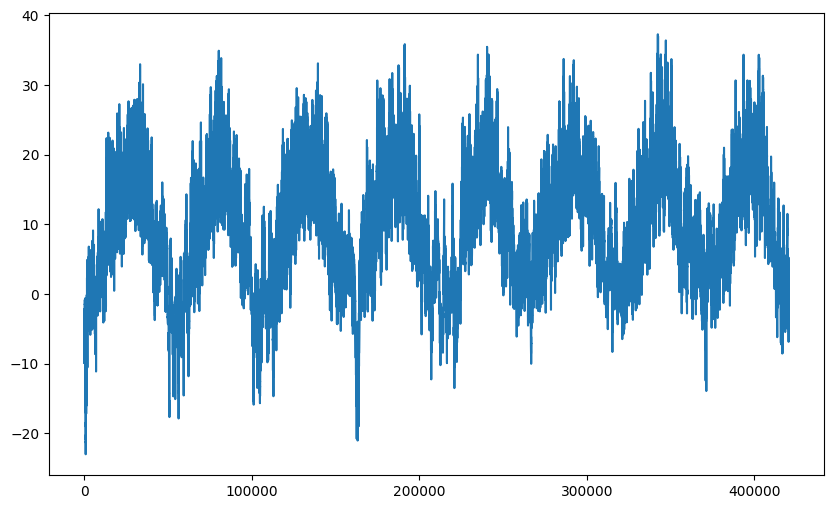

In [5]:
#Plotting
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(range(len(temperature)), temperature)

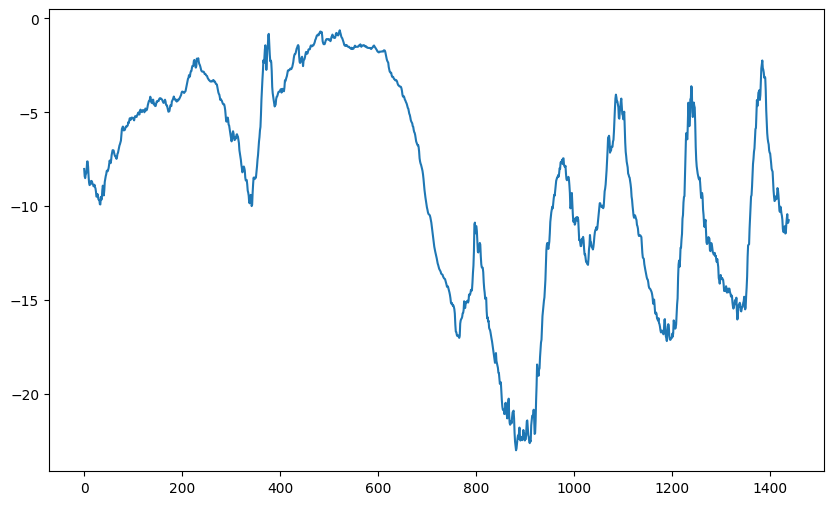

In [6]:
#Plotting the first 10 days of the temperature timeseries
plt.figure(figsize=(10,6))
plt.plot(range(1440), temperature[:1440])

**Normalize the raw data (using training set statistics)**

In [31]:
#  Normalize the raw data (using training set statistics)

num_train = int(num_samples * 0.5)
num_val = int(num_samples * 0.25)
num_test = num_samples - num_train - num_val

mean = raw_data[:num_train].mean(axis=0)
std = raw_data[:num_train].std(axis=0)
raw_data_norm = (raw_data - mean) / std

print("Data normalized. Mean of training set:", mean)


Data normalized. Mean of training set: [ 988.93915      8.825914   282.91495      4.3133245   75.87322
   13.145622     9.19411      3.9514666    5.810532     9.302073
 1218.4553       2.149805     3.560627   176.44116  ]


**Define constants and create tf.data datasets for all methods**

In [32]:
# Define constants and create tf.data datasets for all methods

import tensorflow as tf
from tensorflow import keras

sampling_rate = 6                  # keep 1 sample every 6 (hourly sampling)
sequence_length = 240              # look back 240 steps (~10 days)
delay = sampling_rate * (sequence_length + 48 - 1)  # predict 48 steps (hours) ahead
batch_size = 256

def create_dataset(raw_data, temperature, start_idx, end_idx, shuffle=True):
    return keras.utils.timeseries_dataset_from_array(
        data=raw_data[:-delay],
        targets=temperature[delay:],
        sampling_rate=sampling_rate,
        sequence_length=sequence_length,
        batch_size=batch_size,
        shuffle=shuffle,
        start_index=start_idx,
        end_index=end_idx
    )

train_dataset = create_dataset(raw_data_norm, temperature, 0, num_train)
val_dataset = create_dataset(raw_data_norm, temperature, num_train, num_train + num_val)
test_dataset = create_dataset(raw_data_norm, temperature, num_train + num_val, None)


**Try 1 - Common-sense baseline: predict last temperature in input sequence as future**

In [33]:
# Try 1 - Common-sense baseline: predict last temperature in input sequence as future

def evaluate_naive_method(dataset):
    total_mae = 0.0
    total_samples = 0
    for samples, targets in dataset:
        # last known temperature in input sequence (scaled back)
        preds = samples[:, -1, 1] * std[1] + mean[1]  # column 1 is temperature
        targets_true = targets.numpy()
        mae = tf.reduce_sum(tf.abs(preds - targets_true))
        total_mae += mae
        total_samples += len(targets_true)
    return total_mae / total_samples

print(f"Naive baseline validation MAE: {evaluate_naive_method(val_dataset):.3f}")
print(f"Naive baseline test MAE: {evaluate_naive_method(test_dataset):.3f}")


Naive baseline validation MAE: 3.222
Naive baseline test MAE: 3.474


**Try 2: A fully connected neural network**

In [40]:
# Try 2: A fully connected neural network
from tensorflow import keras
from tensorflow.keras import layers

# Define the model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# Define callbacks to save the best model
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best saved model
model = keras.models.load_model("jena_dense.keras")

# Evaluate on the test set
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 23.3275 - mae: 3.7338 - val_loss: 16.7634 - val_mae: 3.2408
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 12.4945 - mae: 2.7940 - val_loss: 20.7405 - val_mae: 3.6101
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 10.8141 - mae: 2.5935 - val_loss: 18.1120 - val_mae: 3.3535
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 9.8047 - mae: 2.4732 - val_loss: 20.8258 - val_mae: 3.6227
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - loss: 9.1613 - mae: 2.3942 - val_loss: 19.5212 - val_mae: 3.4916
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 8.6813 - mae: 2.3286 - val_loss: 22.5901 - val_mae: 3.7939
Epoch 7/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 8.3264 - mae: 2.2855 - val_loss: 20.5579 - val_mae: 3.5640
Epoch 8/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 7.9633 - mae: 2.2327 - val_loss: 20.8201 - val_mae: 3.5808
Epoch 9/10
815/815 ━━━━━━━━━━

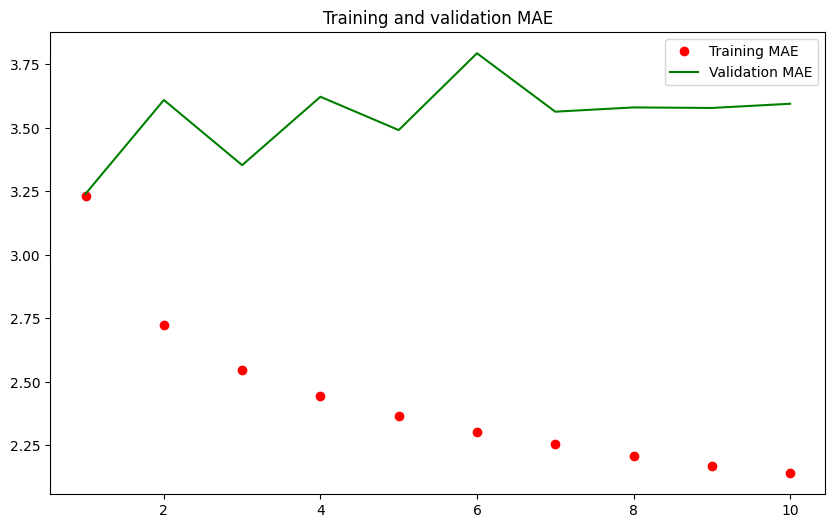

In [42]:
#Plotting
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, 'g', label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try 3: 1D Convolutional Neural Network**

In [43]:
# Try 3: 1D Convolutional Neural Network
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(32, kernel_size=5, activation="relu")(inputs)
x = layers.Conv1D(32, kernel_size=5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1)(x)

model_conv = keras.Model(inputs, outputs)
model_conv.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks_conv = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

history_conv = model_conv.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks_conv
)

model_conv = keras.models.load_model("jena_conv.keras")
test_loss, test_mae = model_conv.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")



Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 150s 183ms/step - loss: 33.7479 - mae: 4.4882 - val_loss: 26.3714 - val_mae: 4.0631
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 151s 185ms/step - loss: 22.6313 - mae: 3.7839 - val_loss: 30.9897 - val_mae: 4.3451
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 166s 204ms/step - loss: 21.1041 - mae: 3.6472 - val_loss: 30.9831 - val_mae: 4.5020
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 164s 201ms/step - loss: 20.0705 - mae: 3.5513 - val_loss: 33.9692 - val_mae: 4.6883
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 160s 195ms/step - loss: 19.2264 - mae: 3.4729 - val_loss: 32.7525 - val_mae: 4.6119
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 160s 196ms/step - loss: 18.4133 - mae: 3.3976 - val_loss: 33.5989 - val_mae: 4.6628
Epoch 7/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 158s 193ms/step - loss: 17.7457 - mae: 3.3331 - val_loss: 32.6613 - val_mae: 4.5726
Epoch 8/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 161s 197ms/step - loss: 17.0975 - mae: 3.2702 - val_loss: 37.6586 - val_mae: 4.9956
Epoch 9/

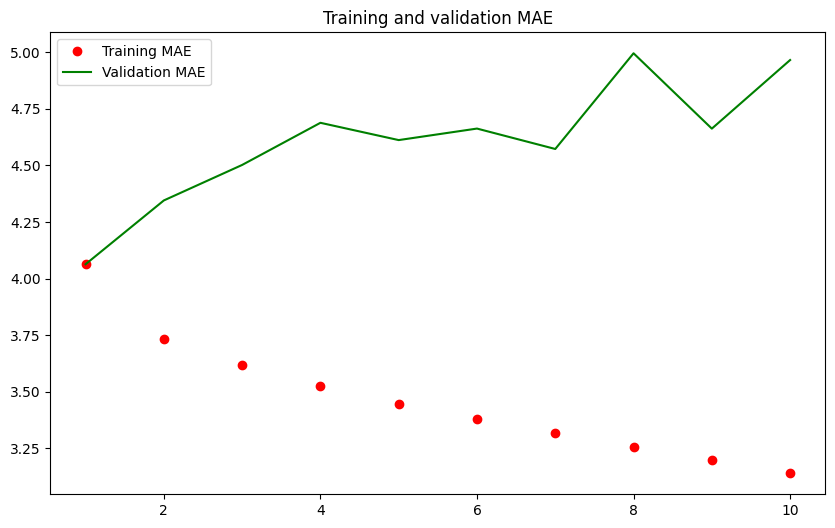

In [44]:
# Plotting
import matplotlib.pyplot as plt
loss = history_conv.history["mae"]
val_loss = history_conv.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, 'g', label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try 4: Simple RNN**

In [45]:
# Try 4: Simple RNN
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(32)(inputs)
outputs = layers.Dense(1)(x)

model_rnn = keras.Model(inputs, outputs)
model_rnn.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks_rnn = [
    keras.callbacks.ModelCheckpoint("jena_rnn.keras", save_best_only=True)
]

history_rnn = model_rnn.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks_rnn
)

model_rnn = keras.models.load_model("jena_rnn.keras")
test_loss, test_mae = model_rnn.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")



Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - loss: 57.1686 - mae: 5.7387 - val_loss: 15.4417 - val_mae: 3.0333
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - loss: 17.1915 - mae: 3.2791 - val_loss: 15.3228 - val_mae: 3.0380
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - loss: 16.5105 - mae: 3.2149 - val_loss: 15.0094 - val_mae: 3.0159
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 16.2259 - mae: 3.1846 - val_loss: 15.4233 - val_mae: 3.0518
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - loss: 15.8500 - mae: 3.1440 - val_loss: 15.2094 - val_mae: 3.0419
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 15.3677 - mae: 3.0927 - val_loss: 15.2850 - val_mae: 3.0595
Epoch 7/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 63s 77ms/step - loss: 15.2287 - mae: 3.0773 - val_loss: 15.2818 - val_mae: 3.0552
Epoch 8/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - loss: 14.9607 - mae: 3.0506 - val_loss: 15.5780 - val_mae: 3.0797
Epoch 9/10
815/815 ━━━━━

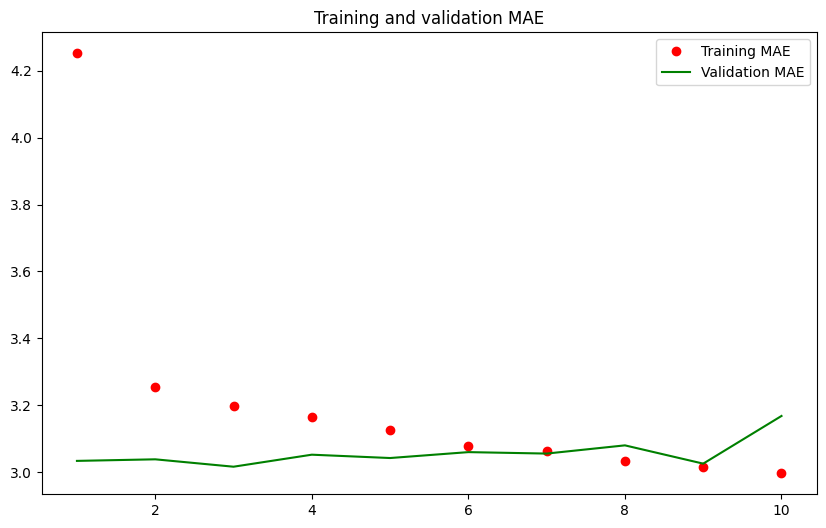

In [46]:
# Plotting
loss = history_rnn.history["mae"]
val_loss = history_rnn.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, 'g', label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try 5: LSTM with Recurrent Dropout**

In [47]:
# Try 5: LSTM with Recurrent Dropout
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)

model_lstm = keras.Model(inputs, outputs)
model_lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks_lstm = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

history_lstm = model_lstm.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks_lstm
)

model_lstm = keras.models.load_model("jena_lstm.keras")
test_loss, test_mae = model_lstm.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")



Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 188s 227ms/step - loss: 51.9445 - mae: 5.3945 - val_loss: 14.8105 - val_mae: 2.9995
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 186s 228ms/step - loss: 15.3895 - mae: 3.1010 - val_loss: 15.2885 - val_mae: 3.0270
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 185s 226ms/step - loss: 14.2889 - mae: 2.9867 - val_loss: 15.7379 - val_mae: 3.0680
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 186s 227ms/step - loss: 13.4951 - mae: 2.9049 - val_loss: 15.8680 - val_mae: 3.0883
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 184s 225ms/step - loss: 12.9082 - mae: 2.8368 - val_loss: 16.1602 - val_mae: 3.1287
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 187s 228ms/step - loss: 12.4278 - mae: 2.7813 - val_loss: 16.3696 - val_mae: 3.1598
Epoch 7/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 186s 228ms/step - loss: 12.0195 - mae: 2.7382 - val_loss: 16.3286 - val_mae: 3.1579
Epoch 8/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 187s 229ms/step - loss: 11.6943 - mae: 2.6980 - val_loss: 16.0030 - val_mae: 3.1353
Epoch 9/

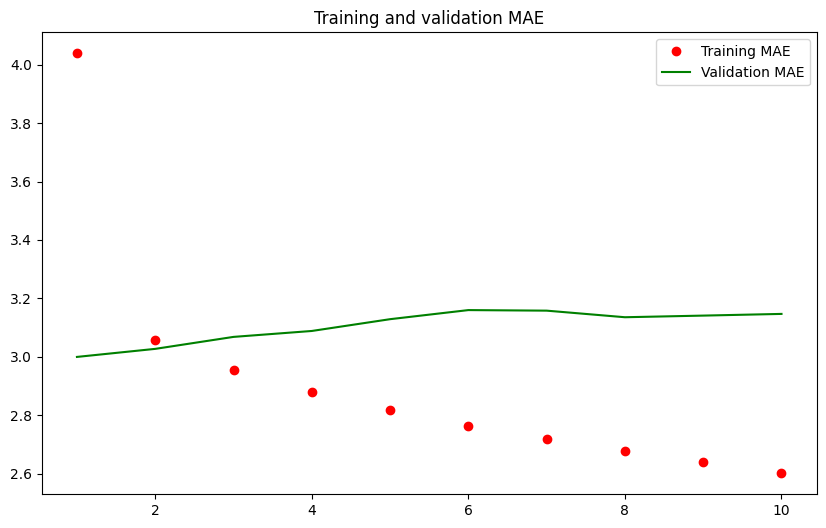

In [48]:
# Plotting
loss = history_lstm.history["mae"]
val_loss = history_lstm.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, 'g', label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try 6: Stacked RNN Layers**

In [49]:
# Try 6: Stacked RNN Layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)

model_stacked = keras.Model(inputs, outputs)
model_stacked.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks_stacked = [
    keras.callbacks.ModelCheckpoint("jena_stacked.keras", save_best_only=True)
]

history_stacked = model_stacked.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks_stacked
)

model_stacked = keras.models.load_model("jena_stacked.keras")
test_loss, test_mae = model_stacked.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")



Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 261s 316ms/step - loss: 44.8124 - mae: 4.9903 - val_loss: 18.0688 - val_mae: 3.3611
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 257s 313ms/step - loss: 12.7138 - mae: 2.7993 - val_loss: 18.3871 - val_mae: 3.4036
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 259s 317ms/step - loss: 9.9964 - mae: 2.4668 - val_loss: 19.1361 - val_mae: 3.4707
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 255s 312ms/step - loss: 8.1888 - mae: 2.2266 - val_loss: 20.6999 - val_mae: 3.5809
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 259s 317ms/step - loss: 6.9263 - mae: 2.0414 - val_loss: 20.5220 - val_mae: 3.5753
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 255s 312ms/step - loss: 5.6358 - mae: 1.8342 - val_loss: 22.1822 - val_mae: 3.6957
Epoch 7/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 253s 309ms/step - loss: 4.8286 - mae: 1.6907 - val_loss: 22.8779 - val_mae: 3.7560
Epoch 8/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 253s 309ms/step - loss: 4.1245 - mae: 1.5586 - val_loss: 23.7388 - val_mae: 3.8459
Epoch 9/10
815

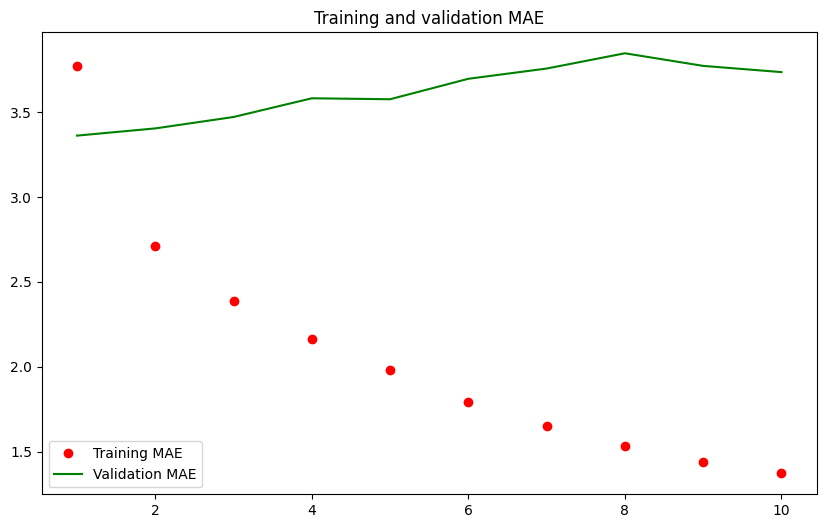

In [50]:
# Plotting
loss = history_stacked.history["mae"]
val_loss = history_stacked.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, 'g', label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Try 7: Bidirectional RNN**

In [51]:
# Try 7: Bidirectional RNN
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(32))(inputs)
outputs = layers.Dense(1)(x)

model_bidir = keras.Model(inputs, outputs)
model_bidir.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks_bidir = [
    keras.callbacks.ModelCheckpoint("jena_bidir.keras", save_best_only=True)
]

history_bidir = model_bidir.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks_bidir
)

model_bidir = keras.models.load_model("jena_bidir.keras")
test_loss, test_mae = model_bidir.evaluate(test_dataset)
print(f"Test MAE: {test_mae:.2f}")




Epoch 1/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 201s 243ms/step - loss: 36.2781 - mae: 4.4542 - val_loss: 17.3414 - val_mae: 3.2631
Epoch 2/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 201s 246ms/step - loss: 12.8419 - mae: 2.8167 - val_loss: 16.7363 - val_mae: 3.1776
Epoch 3/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 201s 245ms/step - loss: 10.8440 - mae: 2.5770 - val_loss: 18.8664 - val_mae: 3.4268
Epoch 4/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 198s 243ms/step - loss: 9.5507 - mae: 2.4097 - val_loss: 20.5168 - val_mae: 3.5839
Epoch 5/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 202s 247ms/step - loss: 8.5797 - mae: 2.2793 - val_loss: 21.3819 - val_mae: 3.6707
Epoch 6/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 200s 244ms/step - loss: 7.7815 - mae: 2.1657 - val_loss: 20.9840 - val_mae: 3.5965
Epoch 7/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 201s 245ms/step - loss: 7.4255 - mae: 2.1160 - val_loss: 21.8993 - val_mae: 3.6752
Epoch 8/10
815/815 ━━━━━━━━━━━━━━━━━━━━ 199s 243ms/step - loss: 6.9282 - mae: 2.0434 - val_loss: 22.3788 - val_mae: 3.7340
Epoch 9/10
81

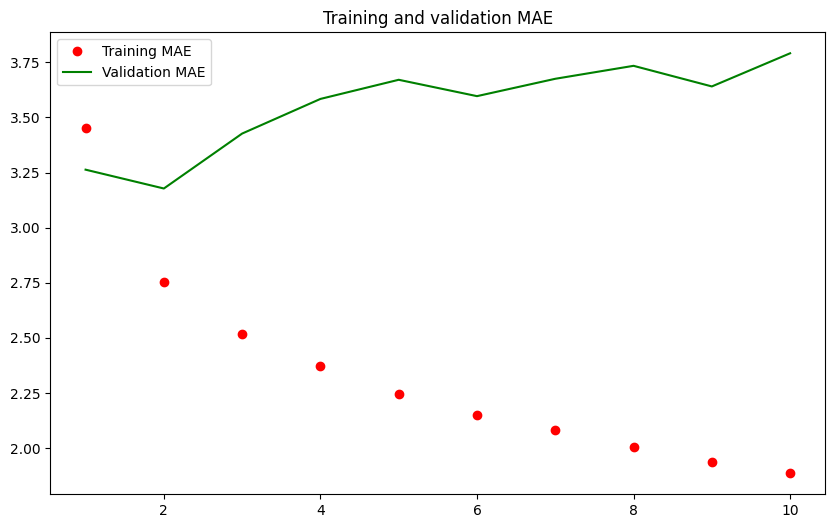

In [52]:
# Plotting
loss = history_bidir.history["mae"]
val_loss = history_bidir.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, 'g', label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()